In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import emcee
import corner

In [2]:
#Cargamos los datos con los que hemos estado trabajando

datos = np.load('test_line.npy')

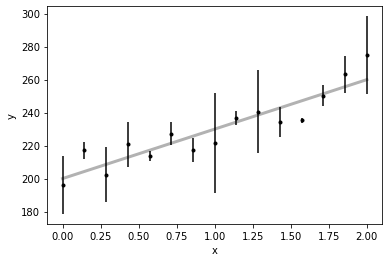

In [3]:
#Parámetros reales

m_real = 30.0
b_real = 200.0
f_real = 0.01

x = datos[0]
y = datos[1]
yerr = datos[2]

x_aux = np.linspace(0, 2, 100)
plt.errorbar(x, y, yerr = yerr, fmt=".k", capsize=0)
plt.plot(x_aux, m_real*x_aux + b_real, "k", alpha=0.3, lw=3)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = 19.339 ± 2.411
b = 206.785 ± 3.165


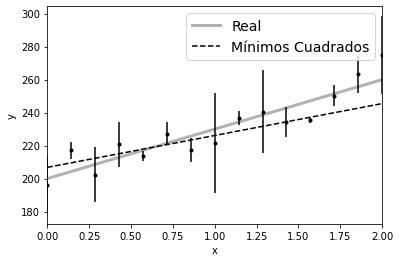

In [4]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_aux, m_real * x_aux + b_real, "k", alpha=0.3, lw=3, label="Real")
plt.plot(x_aux, np.dot(np.vander(x_aux, 2), w), "--k", label="Mínimos Cuadrados")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [5]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 22.483
b = 205.969
f = 0.018


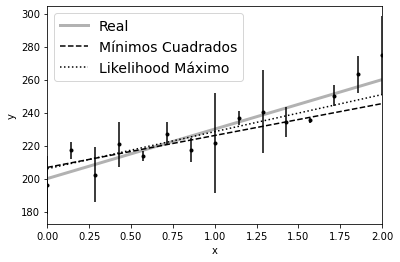

In [6]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_real, b_real, np.log(f_real)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_aux, m_real * x_aux + b_real, "k", alpha=0.3, lw=3, label="Real")
plt.plot(x_aux, np.dot(np.vander(x_aux, 2), w), "--k", label="Mínimos Cuadrados")
plt.plot(x_aux, np.dot(np.vander(x_aux, 2), [m_ml, b_ml]), ":k", label="Likelihood Máximo")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [7]:
def log_prior(theta):
    m, b, log_f = theta
    if 20 < m < 50 and 180 < b < 240 and -5.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [8]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [9]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [01:24<00:00, 117.65it/s]


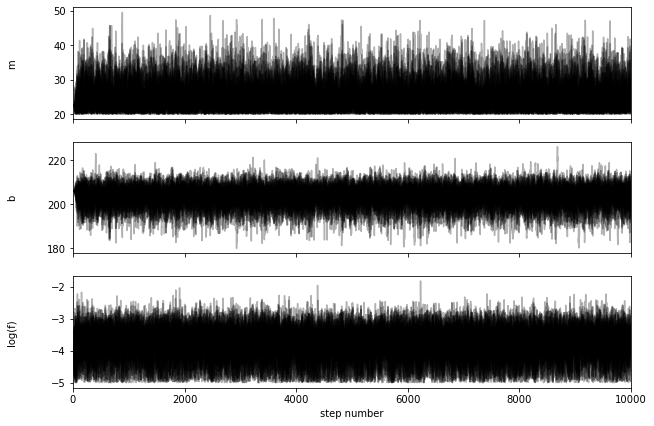

In [10]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[45.04056801 43.97154523 42.19192982]


In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(21120, 3)


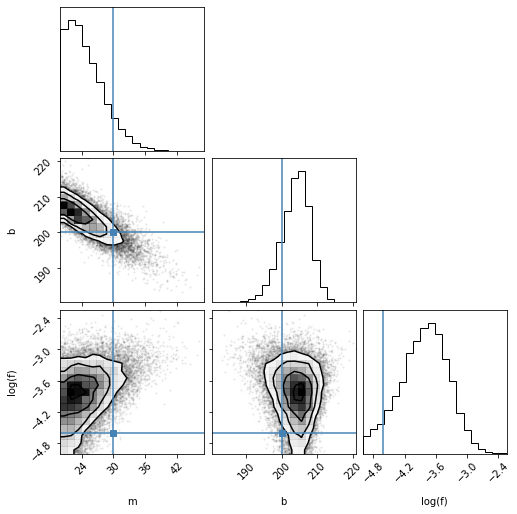

In [13]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_real, b_real, np.log(f_real)]
);

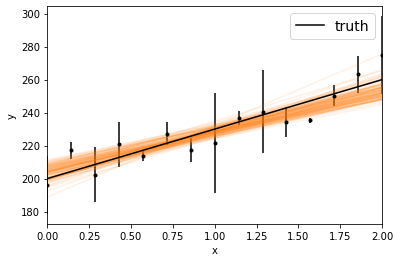

In [15]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_aux, np.dot(np.vander(x_aux, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_aux, m_real * x_aux + b_real, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [16]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>